In [305]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from __future__ import division
from random import choice
from math import log, sqrt
from numpy.random import randint

<IPython.core.display.Javascript object>


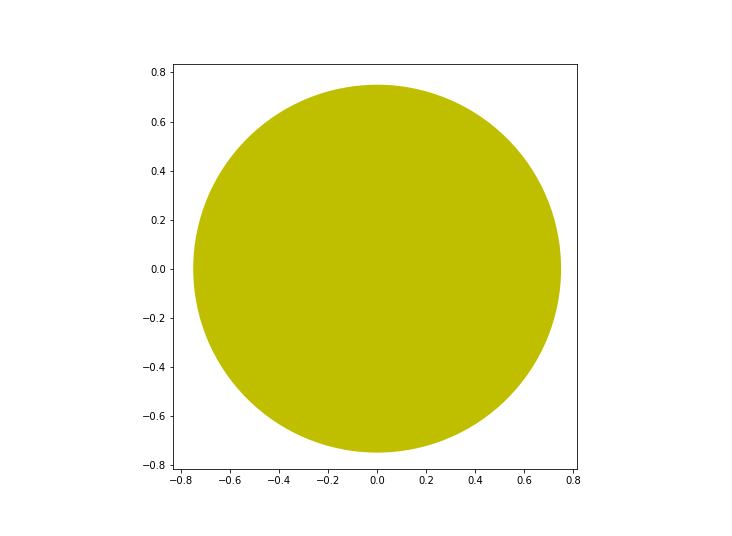

In [10]:
plt.axes()

circle = plt.Circle((0, 0), radius=0.75, fc='y')
plt.gca().add_patch(circle)

plt.axis('scaled')
plt.show()

In [258]:
class Board(object):
    def __init__(self, n, m, d, Rs, Rc, O):
        self.n = n
        self.m = m
        self.d = d
        self.Rs = Rs
        self.Rc = Rc
        self.O = O
        O2 = []
        for x1, y1, x2, y2 in O:
            for x in range(x1, x2+1):
                for y in range(y1, y2+1):
                    O2.append((x, y))
        self.O2 = O2
        self.O2set = set(O2)
    
    def start(self):
        # Returns a representation of the starting state of the game.
        return [(-1,-1)] * self.m

    def next_state(self, state, play):
        # Takes the game state, and the move to be applied.
        # Returns the new game state.
        try:
            t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
        except StopIteration:
            return state
        state_copy = state[:]
        state_copy[t] = play
        return state_copy

    def legal_plays(self, state_history):
        # Takes a sequence of game states representing the full
        # game history, and returns the full list of moves that
        # are legal plays for the current player.
        state = state_history[-1]
        legal = []
#         try:
#             t = next(i for i,p in enumerate(state) if p[0] < 0 or p[1] < 0)
#         except StopIteration:
#             return []
        n = self.n
        m = self.m
        Rs = self.Rs
        Rc = self.Rc
        t = -1
        for i in range(m):
            try:
                x, y = state[i]
            except TypeError:
                return []
            if x < 0 or y < 0:
                t = i
                break
        if t == -1:
            return []
        if t == 0:
            # First iteration anywhere but inside obstacles
            for j in range(0, n+1):
                for k in range(0, n+1):
                    if (j, k) not in self.O2set:
                        legal.append((j, k))
        else:
            # Loop through deployed positions
            for i in range(0, t):
                x, y = state[i]
                # Eliminate out of bound positions
                if x < 0 or y < 0 or x > n or y > n:
                    continue
                # Loop through possible deploy positions
                # (j, k) = possible position
                for j in range(x - Rc[i] - Rc[t] + 1, x + Rc[i] + Rc[t]):
                    for k in range(y - Rc[i] - Rc[t] + 1, y + Rc[i] + Rc[t]):
                        # Eliminate out of bound positions
                        if j < 0 or k < 0 or j > n or k > n:
                            continue
                        # Eliminate deployed positions
                        if (j, k) in state:
                            continue
                        # Eliminate inside obstacles
                        if (j, k) in self.O2:
                            continue
                        overlap = []
                        # Loop through possible coverage
                        # (u, v) = points in sensor i
                        # Need to determine if (u, v) is in coverage of sensor t deployed at (j,k)
                        for u in range(x - Rc[i], x + Rc[i] + 1):
                            for v in range(y - Rc[i], y + Rc[i] + 1):
                                # Eliminate out of bound
                                if u < 0 or v < 0 or u > n or v > n:
                                    continue
                                # Eliminate out of circle
                                if sqrt((u-x)*(u-x) + (v-y)*(v-y)) > Rc[i]:
                                    continue
                                # Determine if (u,v) is covered by sensor t
                                if sqrt((u-j)*(u-j) + (v-k)*(v-k)) <= Rc[t]:
                                    overlap.append((u, v))
                        if len(overlap) >= 2 and set(overlap).issubset(self.O2set) is False:
                            legal.append((j,k))
        return legal

    def winner(self, state_history):
        # Takes a sequence of game states representing the full
        # game history.  If the game is now won, return the player
        # number.  If the game is still ongoing, return zero.  If
        # the game is tied, return a different distinct value, e.g. -1.
        pass

In [247]:
class MonteCarlo(object):
    def __init__(self, board, **kwargs):
        # Takes an instance of a Board and optionally some keyword
        # arguments.  Initializes the list of game states and the
        # statistics tables.
        self.board = board
        self.states = []
        seconds = kwargs.get('time', 30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves', 100)
        self.C = kwargs.get('C', 1.4)
        self.scores = {}
        self.plays = {}
        pass

    def update(self, state):
        # Takes a game state, and appends it to the history.
        self.states.append(state)
        pass

    def get_play(self):
        # Causes the AI to calculate the best move from the
        # current game state and return it.
        self.max_depth = 0
        state = self.states[-1]
        legal = self.board.legal_plays(self.states[:])

        # Bail out early if there is no real choice to be made.
        if not legal:
            return
        if len(legal) == 1:
            return legal[0]

        games = 0
        begin = datetime.datetime.utcnow()
        while datetime.datetime.utcnow() - begin < self.calculation_time:
            self.run_simulation()
            games += 1

        moves_states = [(p, self.board.next_state(state, p)) for p in legal]

        # Display the number of calls of `run_simulation` and the
        # time elapsed.
        print(games, datetime.datetime.utcnow() - begin)

        # Pick the move with the highest score.
        percent_scores, move = max(
            (self.scores.get(tuple(S), 0) /
             self.plays.get(tuple(S), 1),
             p)
            for p, S in moves_states
        )

        # Display the stats for each possible play.
        for x in sorted(
            ((self.scores.get(tuple(S), 0) /
              self.plays.get(tuple(S), 1),
              self.scores.get(tuple(S), 0),
              self.plays.get(tuple(S), 0), p)
             for p, S in moves_states),
            reverse=True
        ):
            print ("{3}: {0:.2f} ({1} / {2})".format(*x))

        print ("Maximum depth searched:", self.max_depth)

        return move

    def run_simulation(self):
        # Plays out a "random" game from the current position,
        # then updates the statistics tables with the result.
        
        # A bit of an optimization here, so we have a local
        # variable lookup instead of an attribute access each loop.
        plays, scores = self.plays, self.scores

        visited_states = set()
        states_copy = self.states[:]
        state = states_copy[-1]

        expand = True
        for t in range(1, self.max_moves + 1):
            legal = self.board.legal_plays(states_copy)
            
            moves_states = [(p, self.board.next_state(state, p)) for p in legal]
            
            if not moves_states:
                continue

            if plays.get(tuple(state)) and plays[tuple(state)] >= 10 and all(plays.get(tuple(S)) for p, S in moves_states):
                # If we have stats on all of the legal moves here, use them.
                log_total = log(
                    sum(plays[tuple(S)] for p, S in moves_states)
                )
                value, move, state = max(
                    ((scores[tuple(S)] / plays[tuple(S)]) +
                     self.C * sqrt(log_total / plays[tuple(S)]), p, S)
                    for p, S in moves_states
                )
            else:
                # Otherwise, just make an arbitrary decision.
                move, state = choice(moves_states)

            states_copy.append(state)

            if expand and tuple(state) not in plays:
                expand = False
                plays[tuple(state)] = 0
                scores[tuple(state)] = 0
                if t > self.max_depth:
                    self.max_depth = t

            visited_states.add(tuple(state))

#             winner = self.board.winner(states_copy)
#             if winner:
#                 break

        for state in visited_states:
            if tuple(state) not in plays:
                continue
            plays[tuple(state)] += 1
            cov = 0
            for x in range(self.board.n+1):
                for y in range(self.board.n+1):
                    for i in range(self.board.m):
                        j, k = state[i]
                        if sqrt((x-j)*(x-j) + (y-k)*(y-k)) <= self.board.Rs[i]:
                            cov += 1
                            break
            scores[tuple(state)] += cov

6552 4080 1.6058823529411765 3.500471830368042


<IPython.core.display.Javascript object>


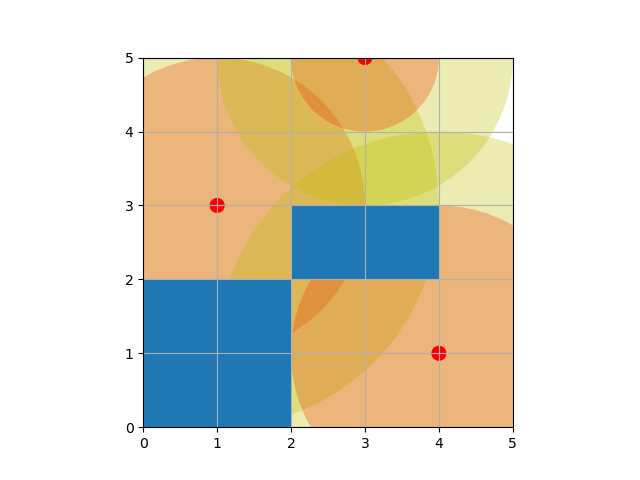

In [314]:
n = 5
m = 3
d = 3
Rs = tuple(randint(1,3,size=m))
Rc = tuple(np.array(Rs) + randint(1,2,size=m))
O = []
for i in range(d):
    x1, y1 = tuple(np.random.randint(0,n-2,size=2))
    x2 = np.random.randint(x1+1, x1+3)
    y2 = np.random.randint(y1+1, y1+3)
    O.append((x1, y1, x2, y2))
board = Board(n, m, d, Rs, Rc, O)
history = [[] for i in range(m+1)]
history[0] = [board.start()]

start = time.time()
for i in range(0, m):
    for state in history[i]:
        legal_plays = board.legal_plays([state])
        if not legal_plays:
            continue
        for play in legal_plays:
            next_state = board.next_state(state, play)
            if next_state not in history[i+1]:
                history[i+1].append(next_state)

possibles = history[-1]

count = len(possibles)
worst = 1
for i in range(0, m):
    worst *= (n+1)*(n+1) - len(board.O2) - i


max_cov = 0
max_deploy = None
for deploy in possibles:
    cov = 0
    for x in range(n+1):
        for y in range(n+1):
            for i in range(m):
                j, k = deploy[i]
                if sqrt((x-j)*(x-j) + (y-k)*(y-k)) <= Rs[i]:
                    cov += 1
                    break
    if cov > max_cov:
        max_deploy = deploy[:]
        max_cov = cov

end = time.time()

print(count, worst, count/worst, end-start)
        
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(which='both')
ax.set_aspect('equal')
ax.set_xticks(np.arange(0,n+1,1))
ax.set_yticks(np.arange(0,n+1,1))

for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=Rs[i], fc='r', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=Rc[i], fc='y', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

for j in range(0, d):
    x1, y1, x2, y2 = O[j]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1)
    plt.gca().add_patch(rect)
    
for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

plt.show()
plt.savefig('4.1.3.png')

In [ ]:
n = 40
m = 30
d = 40
Rs = tuple(np.random.randint(1,4,size=m))
Rc = tuple(np.array(Rs) + np.random.randint(1,3,size=m))
O = []
for i in range(d):
    x1, y1 = tuple(np.random.randint(0,n-2,size=2))
    x2 = np.random.randint(x1+1, x1+4)
    y2 = np.random.randint(y1+1, y1+4)
    O.append((x1, y1, x2, y2))
board = Board(n, m, d, Rs, Rc, O)
montecarlo = MonteCarlo(board, time=30)
montecarlo.update(board.start())
for i in range(0, m):
    move = montecarlo.get_play()
    print('This is move', move)
    montecarlo.update(board.next_state(montecarlo.states[-1], move))

max_deploy = montecarlo.states[-1]
print(max_deploy)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(which='both')
ax.set_aspect('equal')
ax.set_xticks(np.arange(0,n+1,1))
ax.set_yticks(np.arange(0,n+1,1))
# plt.clf()
# plt.axes()

for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=Rs[i], fc='r', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=Rc[i], fc='y', alpha=0.3)
    plt.gca().add_patch(circle)
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

for j in range(0, d):
    x1, y1, x2, y2 = O[j]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1)
    plt.gca().add_patch(rect)
    
for i in range(0, m):
    x, y = max_deploy[i]
    circle = plt.Circle((x, y), radius=0.1, fc='r', alpha=1)
    plt.gca().add_patch(circle)

# plt.axis('scaled')
# plt.grid(color='black', linestyle='-', alpha=0.5, linewidth=1)
plt.show()
plt.savefig('sample3.png')

3 0:00:39.242729
(12, 18): 33.00 (33 / 1)
(10, 7): 33.00 (33 / 1)
(1, 20): 27.00 (27 / 1)
(40, 40): 0.00 (0 / 0)
(40, 39): 0.00 (0 / 0)
(40, 38): 0.00 (0 / 0)
(40, 37): 0.00 (0 / 0)
(40, 36): 0.00 (0 / 0)
(40, 35): 0.00 (0 / 0)
(40, 34): 0.00 (0 / 0)
(40, 33): 0.00 (0 / 0)
(40, 32): 0.00 (0 / 0)
(40, 31): 0.00 (0 / 0)
(40, 30): 0.00 (0 / 0)
(40, 29): 0.00 (0 / 0)
(40, 28): 0.00 (0 / 0)
(40, 27): 0.00 (0 / 0)
(40, 26): 0.00 (0 / 0)
(40, 25): 0.00 (0 / 0)
(40, 24): 0.00 (0 / 0)
(40, 23): 0.00 (0 / 0)
(40, 22): 0.00 (0 / 0)
(40, 21): 0.00 (0 / 0)
(40, 20): 0.00 (0 / 0)
(40, 19): 0.00 (0 / 0)
(40, 18): 0.00 (0 / 0)
(40, 17): 0.00 (0 / 0)
(40, 16): 0.00 (0 / 0)
(40, 15): 0.00 (0 / 0)
(40, 14): 0.00 (0 / 0)
(40, 13): 0.00 (0 / 0)
(40, 12): 0.00 (0 / 0)
(40, 11): 0.00 (0 / 0)
(40, 10): 0.00 (0 / 0)
(40, 9): 0.00 (0 / 0)
(40, 8): 0.00 (0 / 0)
(40, 7): 0.00 (0 / 0)
(40, 6): 0.00 (0 / 0)
(40, 5): 0.00 (0 / 0)
(40, 4): 0.00 (0 / 0)
(40, 3): 0.00 (0 / 0)
(40, 2): 0.00 (0 / 0)
(40, 1): 0.00 (0 / 0)

2 0:00:31.340015
(14, 15): 37.00 (37 / 1)
(14, 19): 34.00 (34 / 1)
(18, 19): 0.00 (0 / 0)
(18, 18): 0.00 (0 / 0)
(18, 17): 0.00 (0 / 0)
(18, 16): 0.00 (0 / 0)
(17, 21): 0.00 (0 / 0)
(17, 20): 0.00 (0 / 0)
(17, 19): 0.00 (0 / 0)
(17, 18): 0.00 (0 / 0)
(16, 22): 0.00 (0 / 0)
(16, 21): 0.00 (0 / 0)
(16, 20): 0.00 (0 / 0)
(16, 19): 0.00 (0 / 0)
(16, 18): 0.00 (0 / 0)
(16, 14): 0.00 (0 / 0)
(15, 23): 0.00 (0 / 0)
(15, 22): 0.00 (0 / 0)
(15, 21): 0.00 (0 / 0)
(15, 20): 0.00 (0 / 0)
(15, 19): 0.00 (0 / 0)
(15, 18): 0.00 (0 / 0)
(15, 17): 0.00 (0 / 0)
(15, 16): 0.00 (0 / 0)
(15, 15): 0.00 (0 / 0)
(15, 14): 0.00 (0 / 0)
(15, 13): 0.00 (0 / 0)
(14, 24): 0.00 (0 / 0)
(14, 23): 0.00 (0 / 0)
(14, 22): 0.00 (0 / 0)
(14, 21): 0.00 (0 / 0)
(14, 20): 0.00 (0 / 0)
(14, 18): 0.00 (0 / 0)
(14, 17): 0.00 (0 / 0)
(14, 16): 0.00 (0 / 0)
(14, 14): 0.00 (0 / 0)
(14, 13): 0.00 (0 / 0)
(14, 12): 0.00 (0 / 0)
(13, 22): 0.00 (0 / 0)
(13, 21): 0.00 (0 / 0)
(13, 20): 0.00 (0 / 0)
(13, 19): 0.00 (0 / 0)
(13, 18): 0.0

2 0:00:31.584424
(9, 13): 78.00 (78 / 1)
(9, 13): 78.00 (78 / 1)
(9, 13): 78.00 (78 / 1)
(15, 20): 73.00 (73 / 1)
(15, 20): 73.00 (73 / 1)
(15, 20): 73.00 (73 / 1)
(15, 20): 73.00 (73 / 1)
(21, 20): 0.00 (0 / 0)
(21, 19): 0.00 (0 / 0)
(21, 18): 0.00 (0 / 0)
(21, 17): 0.00 (0 / 0)
(21, 16): 0.00 (0 / 0)
(20, 19): 0.00 (0 / 0)
(20, 18): 0.00 (0 / 0)
(20, 17): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 14): 0.00 (0 / 0)
(20, 13): 0.00 (0 / 0)
(20, 12): 0.00 (0 / 0)
(19, 19): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 17): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 12): 0.00 (0 / 0)
(19, 11): 0.00 (0 / 0)
(19, 10): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 18): 0.00 (0 / 0)
(18, 1

2 0:00:31.656490
(9, 18): 86.00 (86 / 1)
(9, 18): 86.00 (86 / 1)
(9, 18): 86.00 (86 / 1)
(13, 16): 78.00 (78 / 1)
(13, 16): 78.00 (78 / 1)
(13, 16): 78.00 (78 / 1)
(13, 16): 78.00 (78 / 1)
(13, 16): 78.00 (78 / 1)
(21, 20): 0.00 (0 / 0)
(21, 19): 0.00 (0 / 0)
(21, 18): 0.00 (0 / 0)
(21, 17): 0.00 (0 / 0)
(21, 16): 0.00 (0 / 0)
(20, 19): 0.00 (0 / 0)
(20, 18): 0.00 (0 / 0)
(20, 17): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 14): 0.00 (0 / 0)
(20, 13): 0.00 (0 / 0)
(20, 12): 0.00 (0 / 0)
(19, 19): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 17): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 12): 0.00 (0 / 0)
(19, 11): 0.00 (0 / 0)
(19, 10): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18,

3 0:00:44.992860
(3, 19): 115.00 (115 / 1)
(6, 11): 111.00 (111 / 1)
(6, 11): 111.00 (111 / 1)
(10, 22): 109.00 (109 / 1)
(10, 22): 109.00 (109 / 1)
(10, 22): 109.00 (109 / 1)
(10, 22): 109.00 (109 / 1)
(23, 20): 0.00 (0 / 0)
(23, 19): 0.00 (0 / 0)
(23, 18): 0.00 (0 / 0)
(23, 17): 0.00 (0 / 0)
(23, 16): 0.00 (0 / 0)
(22, 22): 0.00 (0 / 0)
(22, 21): 0.00 (0 / 0)
(22, 20): 0.00 (0 / 0)
(22, 19): 0.00 (0 / 0)
(22, 18): 0.00 (0 / 0)
(22, 17): 0.00 (0 / 0)
(22, 17): 0.00 (0 / 0)
(22, 16): 0.00 (0 / 0)
(22, 16): 0.00 (0 / 0)
(22, 15): 0.00 (0 / 0)
(22, 15): 0.00 (0 / 0)
(22, 14): 0.00 (0 / 0)
(22, 14): 0.00 (0 / 0)
(22, 13): 0.00 (0 / 0)
(22, 12): 0.00 (0 / 0)
(22, 11): 0.00 (0 / 0)
(21, 23): 0.00 (0 / 0)
(21, 22): 0.00 (0 / 0)
(21, 21): 0.00 (0 / 0)
(21, 20): 0.00 (0 / 0)
(21, 19): 0.00 (0 / 0)
(21, 18): 0.00 (0 / 0)
(21, 18): 0.00 (0 / 0)
(21, 17): 0.00 (0 / 0)
(21, 17): 0.00 (0 / 0)
(21, 16): 0.00 (0 / 0)
(21, 16): 0.00 (0 / 0)
(21, 15): 0.00 (0 / 0)
(21, 15): 0.00 (0 / 0)
(21, 14): 0.00 

3 0:00:43.748443
(21, 17): 128.00 (128 / 1)
(20, 12): 128.00 (128 / 1)
(14, 19): 117.00 (117 / 1)
(14, 19): 117.00 (117 / 1)
(14, 19): 117.00 (117 / 1)
(14, 19): 117.00 (117 / 1)
(14, 19): 117.00 (117 / 1)
(21, 20): 0.00 (0 / 0)
(21, 19): 0.00 (0 / 0)
(21, 18): 0.00 (0 / 0)
(21, 16): 0.00 (0 / 0)
(20, 19): 0.00 (0 / 0)
(20, 18): 0.00 (0 / 0)
(20, 17): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 16): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 15): 0.00 (0 / 0)
(20, 14): 0.00 (0 / 0)
(20, 13): 0.00 (0 / 0)
(19, 19): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 18): 0.00 (0 / 0)
(19, 17): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 16): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 15): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 14): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 13): 0.00 (0 / 0)
(19, 12): 0.00 (0 / 0)
(19, 11): 0.00 (0 / 0)
(19, 10): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 19): 0.00 (0 / 0)
(18, 18): 0.00 (0 / 0)
(18, 18): 0.00 (0 / 0)
(18, 18): 0.

3 0:00:42.794483
(15, 22): 153.00 (153 / 1)
(15, 22): 153.00 (153 / 1)
(15, 22): 153.00 (153 / 1)
(15, 22): 153.00 (153 / 1)
(15, 22): 153.00 (153 / 1)
(8, 19): 142.00 (142 / 1)
(8, 19): 142.00 (142 / 1)
(8, 19): 142.00 (142 / 1)
(8, 19): 142.00 (142 / 1)
(8, 19): 142.00 (142 / 1)
(8, 19): 142.00 (142 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(12, 19): 133.00 (133 / 1)
(28, 16): 0.00 (0 / 0)
(28, 15): 0.00 (0 / 0)
(27, 21): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(27, 14): 0.00 (0 / 0)
(27, 13): 0.00 (0 / 0)
(26, 22): 0.00 (0 / 0)
(26, 21): 0.00 (0 / 0)
(25, 23): 0.00 (0 / 0)
(25, 22): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(24, 23): 0.00 (0 / 0)
(24, 22): 0.00 (0 / 0)
(24, 21): 0.00 (0 / 0)
(24, 20): 0.00 (0 / 0)
(24, 19): 0.00 (0 / 0)
(24, 18): 0.00 (0 / 0)
(24, 17): 0.00 (0 / 0)
(24, 12): 0.00 (0 / 0)
(24, 11): 0.00 (0 / 0)
(23, 24): 0.00 (0 / 

3 0:00:42.113013
(18, 17): 168.00 (168 / 1)
(18, 17): 168.00 (168 / 1)
(18, 17): 168.00 (168 / 1)
(18, 17): 168.00 (168 / 1)
(18, 17): 168.00 (168 / 1)
(18, 17): 168.00 (168 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 21): 165.00 (165 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(11, 16): 155.00 (155 / 1)
(28, 16): 0.00 (0 / 0)
(28, 15): 0.00 (0 / 0)
(27, 21): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(27, 14): 0.00 (0 / 0)
(27, 13): 0.00 (0 / 0)
(26, 22): 0.00 (0 / 0)
(26, 21): 0.00 (0 / 0)
(25, 23): 0.00 (0 / 0)
(25, 22): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(24, 23): 0.00 (0 / 0)
(24, 22): 0.00 (0 / 0)
(24, 21): 0.00 (0 / 0)
(24, 20): 0.00 (0 / 0)
(24, 19): 0.00 (0 / 0)
(24, 19): 0.00 (0 / 0)
(2

3 0:00:41.708513
(19, 12): 173.00 (173 / 1)
(19, 12): 173.00 (173 / 1)
(19, 12): 173.00 (173 / 1)
(10, 11): 171.00 (171 / 1)
(10, 11): 171.00 (171 / 1)
(8, 18): 168.00 (168 / 1)
(8, 18): 168.00 (168 / 1)
(8, 18): 168.00 (168 / 1)
(8, 18): 168.00 (168 / 1)
(8, 18): 168.00 (168 / 1)
(24, 21): 0.00 (0 / 0)
(24, 21): 0.00 (0 / 0)
(24, 20): 0.00 (0 / 0)
(24, 20): 0.00 (0 / 0)
(24, 19): 0.00 (0 / 0)
(24, 19): 0.00 (0 / 0)
(24, 18): 0.00 (0 / 0)
(24, 18): 0.00 (0 / 0)
(24, 17): 0.00 (0 / 0)
(24, 17): 0.00 (0 / 0)
(23, 22): 0.00 (0 / 0)
(23, 22): 0.00 (0 / 0)
(23, 21): 0.00 (0 / 0)
(23, 21): 0.00 (0 / 0)
(23, 20): 0.00 (0 / 0)
(23, 20): 0.00 (0 / 0)
(23, 19): 0.00 (0 / 0)
(23, 19): 0.00 (0 / 0)
(23, 18): 0.00 (0 / 0)
(23, 18): 0.00 (0 / 0)
(23, 17): 0.00 (0 / 0)
(23, 17): 0.00 (0 / 0)
(23, 16): 0.00 (0 / 0)
(23, 16): 0.00 (0 / 0)
(23, 15): 0.00 (0 / 0)
(23, 15): 0.00 (0 / 0)
(23, 14): 0.00 (0 / 0)
(23, 14): 0.00 (0 / 0)
(23, 13): 0.00 (0 / 0)
(23, 13): 0.00 (0 / 0)
(23, 12): 0.00 (0 / 0)
(23, 

3 0:00:40.682013
(22, 19): 191.00 (191 / 1)
(22, 19): 191.00 (191 / 1)
(22, 19): 191.00 (191 / 1)
(22, 19): 191.00 (191 / 1)
(22, 16): 189.00 (189 / 1)
(22, 16): 189.00 (189 / 1)
(22, 16): 189.00 (189 / 1)
(22, 16): 189.00 (189 / 1)
(22, 16): 189.00 (189 / 1)
(22, 16): 189.00 (189 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(15, 18): 173.00 (173 / 1)
(28, 16): 0.00 (0 / 0)
(28, 15): 0.00 (0 / 0)
(27, 21): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(27, 14): 0.00 (0 / 0)
(27, 14): 0.00 (0 / 0)
(27, 13): 0.00 (0 / 0)
(26, 22): 0.00 (0 / 0)
(26, 22): 0.00 (0 / 0)
(26, 21): 0.00 (0 / 0)
(26, 21): 0.00 (0 / 0)
(25, 23): 0.00 (0 / 0)
(25, 23): 0.00 (0 / 0)
(25, 22): 0.00 (0 / 0)
(25, 22): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(25, 8): 0

3 0:00:38.032074
(26, 23): 204.00 (204 / 1)
(4, 17): 195.00 (195 / 1)
(4, 17): 195.00 (195 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(15, 14): 193.00 (193 / 1)
(30, 21): 0.00 (0 / 0)
(29, 23): 0.00 (0 / 0)
(29, 22): 0.00 (0 / 0)
(29, 21): 0.00 (0 / 0)
(29, 20): 0.00 (0 / 0)
(29, 19): 0.00 (0 / 0)
(28, 25): 0.00 (0 / 0)
(28, 24): 0.00 (0 / 0)
(28, 23): 0.00 (0 / 0)
(28, 22): 0.00 (0 / 0)
(28, 21): 0.00 (0 / 0)
(27, 25): 0.00 (0 / 0)
(27, 24): 0.00 (0 / 0)
(27, 23): 0.00 (0 / 0)
(27, 22): 0.00 (0 / 0)
(27, 21): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 16): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(27, 15): 0.00 (0 / 0)
(26, 22): 0.00 (0 / 0)
(26, 21): 0.00 (0 / 0)
(25, 23): 0.00 (0 / 0)
(25, 22): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(25, 21): 0.00 (0 / 0)
(24, 23): 0.00 (0 / 0)
(24, 23): 0.00 (0 / 0)
(24, 22): 0.00 (0 / 0

3 0:00:37.006336
(9, 21): 214.00 (214 / 1)
(9, 21): 214.00 (214 / 1)
(9, 21): 214.00 (214 / 1)
(9, 21): 214.00 (214 / 1)
(20, 15): 209.00 (209 / 1)
(20, 15): 209.00 (209 / 1)
(20, 15): 209.00 (209 / 1)
(20, 15): 209.00 (209 / 1)
(20, 15): 209.00 (209 / 1)
(20, 15): 209.00 (209 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(11, 16): 205.00 (205 / 1)
(32, 23): 0.00 (0 / 0)
(32, 22): 0.00 (0 / 0)
(32, 21): 0.00 (0 / 0)
(31, 23): 0.00 (0 / 0)
(31, 22): 0.00 (0 / 0)
(31, 21): 0.00 (0 / 0)
(31, 20): 0.00 (0 / 0)
(30, 27): 0.00 (0 / 0)
(30, 23): 0.00 (0 / 0)
(30, 22): 0.00 (0 / 0)
(30, 21): 0.00 (0 / 0)
(30, 20): 0.00 (0 / 0)
(30, 19): 0.00 (0 / 0)
(29, 28): 0.00 (0 / 0)
(29, 27): 0.00 (0 / 0)
(29, 26): 0.00 (0 / 0)
(29, 25): 0.00 (0 / 0)
(29, 24): 0.00 (0 / 0)
(29, 23): 0.00 (0 / 0)
(29, 22): 0.00 (0 / 0)
(29, 21): 0.00 (0 / 0)
(29, 21): 0.00 (0 

In [300]:
plt.savefig('sample.png')